# Dirichlet model fitting to nutrient productivity
Based on http://dirichletreg.r-forge.r-project.org/


In [17]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import ternary
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os
import arviz as az
from matplotlib.patches import Ellipse, transforms
from itertools import combinations
#import ternary

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

# Posterior draws for each covariate, save as csv
def extract_con(alpha, varname):

    # covariate trace
    alphas = trace_dm[alpha].T

    # get posterior mean
    alpha_0 = alphas.sum(0).mean(1)
    Ex_alphas = alphas.mean(2)
    Ex = pd.DataFrame(Ex_alphas/alpha_0).T
    Ex.to_csv('fg/zinc/zinc_posterior_'+varname+'.csv', index=False)

    # get HPDI
    Ex_hpd = np.array([az.hdi(a) for a in alphas.transpose(0,2,1)])
    Ex_hpd_lo = pd.DataFrame([a[:,0]/alpha_0 for a in Ex_hpd]).T
    Ex_hpd_hi = pd.DataFrame([a[:,1]/alpha_0 for a in Ex_hpd]).T
    Ex_hpd_lo.to_csv('fg/zinc/zinc_posterior_'+varname+'_hpd_lo.csv', index=False)
    Ex_hpd_hi.to_csv('fg/zinc/zinc_posterior_'+varname+'_hpd_hi.csv', index=False)

Dataset are proportion of nutrient productivity by fish functional groups, for zinc.mg

In [18]:
# Import data
nut = pd.read_csv("zinc.mg_unscaled.csv")
nut.head()
# hnames

,Unnamed: 0,nutrient,nutrient_lab,country,site,year,hard_coral,macroalgae,turf_algae,bare_substrate,...,grav_nc,sediment,nutrient_load,pop_count,herbivore-detritivore,herbivore-macroalgae,invertivore-mobile,omnivore,piscivore,planktivore
0,1,zinc.mg,Zinc,Belize,CZFR1,2019,22.67,42.33,5.50,0.0,...,0.098334,0.0,0.000000,1.309482,0.427136,0.192902,0.080209,0.0,0.083190,0.216562
1,2,zinc.mg,Zinc,Belize,CZFR2,2019,17.89,33.05,25.63,0.0,...,0.098334,0.0,0.000000,1.309482,0.445783,0.423935,0.048006,0.0,0.048631,0.033645
2,3,zinc.mg,Zinc,Belize,CZFR3,2019,23.83,38.33,11.67,0.0,...,0.098334,0.0,0.000000,1.309482,0.678792,0.103208,0.085183,0.0,0.054845,0.077972
3,4,zinc.mg,Zinc,Belize,CZPR1,2019,5.83,37.50,9.83,0.0,...,0.134825,0.0,0.000002,1.309482,0.270988,0.665021,0.022221,0.0,0.041769,0.000000
4,5,zinc.mg,Zinc,Belize,CZPR4,2019,9.67,53.00,1.33,0.0,...,0.134825,0.0,0.000002,1.309482,0.116333,0.631506,0.045739,0.0,0.206422,0.000000


In [19]:
# Import data
nut = pd.read_csv("zinc.mg_unscaled.csv")
nut.head()
nut.management_rules = nut.country + nut.management_rules

# y = nut[["browser","cropper/grazer","invertivore-mobile","scraper-excavator","piscivore","planktivore", "mixed-diet feeder"]]
y = nut[["herbivore-detritivore","herbivore-macroalgae","invertivore-mobile","piscivore","planktivore", "omnivore"]]
# Grab fg names
hnames = list(y[:-1])
y = y.to_numpy()
y = y.round(2)+0.000001
# Make y's sum to 1
y = y/y.sum(axis=1,keepdims=1)
nfg = y.shape[1]

# export fitted df
y2=pd.DataFrame(y)
y2.to_csv('zinc_focal.csv', index=False)

# # identify predictors
hc = stdize(nut.hard_coral).to_numpy()
ma = stdize(nut.macroalgae).to_numpy()
bs = stdize(nut.bare_substrate).to_numpy()
ta = stdize(nut.turf_algae).to_numpy()
rub = stdize(nut.rubble).to_numpy()
pop = stdize(nut.pop_count).to_numpy()
rt = pd.Categorical(nut.reef_type)
grav_nc = stdize(nut.grav_nc).to_numpy()
nl = stdize(nut.nutrient_load).to_numpy()
sed = stdize(nut.sediment).to_numpy()
dep = stdize(nut.depth).to_numpy()

## categorical levels
reef_type = list(np.sort(pd.unique(nut["reef_type"])))
rt = np.array([reef_type.index(x) for x in nut["reef_type"]])

reef_zone = list(np.sort(pd.unique(nut["reef_zone"])))
rz = np.array([reef_zone.index(x) for x in nut["reef_zone"]])

manage = list(np.sort(pd.unique(nut["management_rules"])))
mr = np.array([manage.index(x) for x in nut["management_rules"]])

# if manage nested in country, use subindexall
country,c = subindexall(nut["country"], nut["management_rules"])
# else
# country = list(np.sort(pd.unique(nut["country"])))
# c = np.array([country.index(x) for x in nut["country"]])

# site is almost n = 1 for all, so would not converge sensibly

Now build the model

In [20]:
country, c

(['Belize', 'Fiji', 'Madagascar', 'Solomon Islands'],
 array([0, 0, 1, 1, 2, 2, 2, 3, 3]))

In [21]:
coords={'reef_type':reef_type, 'country':country,'nfg':nfg}

with pm.Model(coords=coords) as BDM:
    intercept = pm.Normal('intercept', 0, 2, shape=nfg)
    
    # conts
    hard_coral = pm.Normal('hard_coral', 0, 0.5, shape=nfg)
    macroalgae = pm.Normal('macroalgae', 0, 0.5, shape=nfg)
    bare_sub = pm.Normal('bare_sub', 0, 0.5, shape=nfg)
    turf = pm.Normal('turf', 0, 0.5, shape=nfg)
    rubble = pm.Normal('rubble', 0, 0.5, shape=nfg)
    population = pm.Normal('population', 0, 0.5, shape=nfg)
    gravity = pm.Normal('gravity', 0, 0.5, shape=nfg)
    sediment = pm.Normal('sediment', 0, 0.5, shape=nfg)
    nut_load = pm.Normal('nut_load', 0, 0.5, shape=nfg)
    depth = pm.Normal('depth', 0, 0.5, shape=nfg)
    
    # cats
    reeftype_x = pm.Normal("reeftype_x", 0, 1, shape = (len(reef_type), nfg))
    reefzone_x = pm.Normal("reefzone_x", 0, 1, shape = (len(reef_zone), nfg))
#     manage_x = pm.Normal("manage_x", 0, 1, shape = (len(manage), nfg))
    
    # country nested in global intercept
    σ_c = pm.Exponential('Sigma_country', 1)
    β0_cnc = pm.Normal('β0_cnc', 0, 1, shape = (len(country), nfg))
    β0_c = pm.Normal('β0_c', intercept+β0_cnc*σ_c, shape = (len(country), nfg))
    
    # Site
#     σ_s = pm.Exponential('Sigma_site', 1)
#     β0_snc = pm.Normal('β0_snc', 0, 1, shape = (len(site), nfg))
#     β0_s = pm.Normal('β0_s', β0_c[c]+β0_snc*σ_c, shape = (len(site), nfg)) 

    # Management nested in country 
    σ_m = pm.Exponential('Sigma_manage', 1)
    β0_managenc = pm.Normal('β0_managenc', 0, 1, shape = (len(manage), nfg))
    β0_manage = pm.Normal('β0_manage', β0_c[c]+β0_managenc*σ_m, shape = (len(manage), nfg)) 

    α = pm.Deterministic('alpha', tt.exp(#intercept +
                                         β0_manage[mr, :None] +
#                                          β0_c[c, :None] +
                                         reeftype_x[rt,:None] + reefzone_x[rz, :None] +
#                                          manage_x[mr,:None] +
                                         hard_coral*hc[:,None]+macroalgae*ma[:,None]+
                                         bare_sub*bs[:,None]+turf*ta[:,None]+rubble*rub[:,None]+
                                         gravity*grav_nc[:,None] + population*pop[:,None]+
                                         sediment*sed[:,None] + nut_load*nl[:,None] +
                                         depth*dep[:,None]))
    Yi = pm.Dirichlet('Yi', α, observed=y)
    
    # Covariate predictions
    gravG = np.linspace(min(grav_nc),max(grav_nc), num=100)
    α2 = pm.Deterministic('alpha2', tt.exp(intercept.mean(0)+gravity*gravG[:,None]))
    
    coralG = np.linspace(min(hc),max(hc), num=100)
    α3 = pm.Deterministic('alpha3', tt.exp(intercept.mean(0)+hard_coral*coralG[:,None]))
    
    macroG = np.linspace(min(ma),max(ma), num=100)
    α4 = pm.Deterministic('alpha4', tt.exp(intercept.mean(0)+macroalgae*macroG[:,None]))
    
    bareG = np.linspace(min(bs),max(bs), num=100)
    α5 = pm.Deterministic('alpha5', tt.exp(intercept.mean(0)+bare_sub*bareG[:,None]))
    
    turfG = np.linspace(min(ta),max(ta), num=100)
    α6 = pm.Deterministic('alpha6', tt.exp(intercept.mean(0)+turf*turfG[:,None]))
    
    # manage is nested in country intercepts, so B0_manage covariate sample is the combined effect
    # B0_managenc covariate sample is the relative management effect
    manageG = np.linspace(0, 8, num = 9).astype(int)
    α7 = pm.Deterministic('alpha7', tt.exp(β0_manage[manageG,:None]))
    
    popG = np.linspace(min(pop),max(pop), num=100)
    α8 = pm.Deterministic('alpha8', tt.exp(intercept.mean(0)+population*popG[:,None]))
    
    sedG = np.linspace(min(sed),max(sed), num=100)
    α9 = pm.Deterministic('alpha9', tt.exp(intercept.mean(0)+sediment*sedG[:,None]))
    
    nlG = np.linspace(min(nl),max(nl), num=100)
    α10 = pm.Deterministic('alpha10', tt.exp(intercept.mean(0)+nut_load*nlG[:,None]))
    
    rubG = np.linspace(min(rub),max(rub), num=100)
    α11 = pm.Deterministic('alpha11', tt.exp(intercept.mean(0)+rubble*rubG[:,None]))
    
    # vectors of management type for each hard_coral gradient
    futureHC = np.repeat(coralG, 9)
    futureG = np.tile(manageG, 100)
    α12 = pm.Deterministic('alpha12', tt.exp(β0_manage[futureG,:None] + hard_coral*futureHC[:,None]))
    
    # nc manage and country effects
    manageGnc = np.linspace(0, 8, num = 9).astype(int)
    α13 = pm.Deterministic('alpha13', tt.exp(β0_managenc[manageG,:None]))
    
    countrync = np.linspace(0, 3, num = 4).astype(int)
    α14 = pm.Deterministic('alpha14', tt.exp(β0_cnc[c,:None]))

In [22]:
# manage, c, country, mr
country

['Belize', 'Fiji', 'Madagascar', 'Solomon Islands']

Note the `[:,None]` in the code is to broadcast the predictor measurements across all fish functional groups.

In [23]:
for RV in BDM.basic_RVs:
    print(RV.name, RV.logp(BDM.test_point))

intercept -9.672514282587708
hard_coral -1.3547481158683645
macroalgae -1.3547481158683645
bare_sub -1.3547481158683645
turf -1.3547481158683645
rubble -1.3547481158683645
population -1.3547481158683645
gravity -1.3547481158683645
sediment -1.3547481158683645
nut_load -1.3547481158683645
depth -1.3547481158683645
reeftype_x -27.56815599614019
reefzone_x -16.540893597684104
Sigma_country_log__ -1.0596601002984287
β0_cnc -22.054524796912148
β0_c -22.054524796912148
Sigma_manage_log__ -1.0596601002984287
β0_managenc -49.62268079305237
β0_manage -49.62268079305237
Yi 1737.8595026298945


In [24]:
with BDM:
    trace_dm = pm.sample()

/opt/miniconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [β0_manage, β0_managenc, Sigma_manage, β0_c, β0_cnc, Sigma_country, reefzone_x, reeftype_x, depth, nut_load, sediment, gravity, population, rubble, turf, bare_sub, macroalgae, hard_coral, intercept]


/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 209 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
pm.summary(trace_dm, var_names=['β0_manage'], filter_vars="regex")

/opt/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"β0_managenc[0,0]",0.023,1.035,-1.894,1.959,0.013,0.022,6425.0,2110.0,1.00
"β0_managenc[0,1]",0.150,1.031,-1.835,1.969,0.013,0.023,5932.0,2098.0,1.00
"β0_managenc[0,2]",0.018,0.987,-1.879,1.874,0.015,0.020,4435.0,2317.0,1.00
"β0_managenc[0,3]",0.027,1.003,-1.795,2.019,0.011,0.020,7814.0,2181.0,1.00
"β0_managenc[0,4]",-0.117,0.951,-1.887,1.725,0.011,0.019,6915.0,2300.0,1.00
...,...,...,...,...,...,...,...,...,...
"β0_manage[8,1]",-1.414,0.756,-2.972,-0.093,0.040,0.029,352.0,762.0,1.01
"β0_manage[8,2]",0.172,0.737,-1.226,1.545,0.042,0.030,308.0,483.0,1.01
"β0_manage[8,3]",-0.522,0.725,-1.887,0.759,0.037,0.026,386.0,630.0,1.00
"β0_manage[8,4]",0.486,0.788,-1.040,1.951,0.056,0.040,201.0,345.0,1.03


In [26]:
pm.summary(trace_dm, var_names=['~^alpha'], filter_vars="regex")

/opt/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[0],0.920,0.878,-0.769,2.527,0.046,0.032,367.0,757.0,1.01
intercept[1],-0.981,0.900,-2.538,0.798,0.040,0.028,515.0,1128.0,1.00
intercept[2],-0.123,0.900,-1.778,1.704,0.043,0.030,442.0,637.0,1.01
intercept[3],-0.317,0.890,-1.961,1.325,0.036,0.026,592.0,1094.0,1.00
intercept[4],-1.052,0.936,-2.838,0.661,0.054,0.038,300.0,588.0,1.02
...,...,...,...,...,...,...,...,...,...
"β0_manage[8,3]",-0.522,0.725,-1.887,0.759,0.037,0.026,386.0,630.0,1.00
"β0_manage[8,4]",0.486,0.788,-1.040,1.951,0.056,0.040,201.0,345.0,1.03
"β0_manage[8,5]",-1.318,0.693,-2.590,-0.001,0.034,0.024,414.0,703.0,1.01
Sigma_country,0.342,0.269,0.000,0.821,0.007,0.005,1511.0,1841.0,1.00


In [27]:
# Export summary stats
tmp = pm.summary(trace_dm, var_names=['~^Sigma', '~^alpha'], hdi_prob=0.95, filter_vars="regex")
varnames = np.array(list(tmp.index), dtype=object)
varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(np.repeat(country, nfg))*2)
varnames[match(grep('β0_manage',list(varnames)),list(varnames))] = np.array(list(np.repeat(manage, nfg))*2)
varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = np.repeat(reef_type, nfg)
varnames[match(grep('reefzone_x',list(varnames)),list(varnames))] = np.repeat(reef_zone, nfg)
# varnames[match(grep('manage_x',list(varname§s)),list(varnames))] = np.repeat(manage, nfg)

tmp['varname'] = list(varnames)
tmp['fg']=int(len(tmp)/nfg)*hnames

tmp.to_csv('fg/zinc/zinc_posterior_summary.csv')

tmp = pm.summary(trace_dm, var_names=['~^Sigma', '~^alpha'], hdi_prob=0.5, filter_vars="regex")
varnames = np.array(list(tmp.index), dtype=object)
varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(np.repeat(country, nfg))*2)
varnames[match(grep('β0_manage',list(varnames)),list(varnames))] = np.array(list(np.repeat(manage, nfg))*2)
varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = np.repeat(reef_type, nfg)
varnames[match(grep('reefzone_x',list(varnames)),list(varnames))] = np.repeat(reef_zone, nfg)
# varnames[match(grep('manage_x',list(varname§s)),list(varnames))] = np.repeat(manage, nfg)

tmp['varname'] = list(varnames)
tmp['fg']=int(len(tmp)/nfg)*hnames

tmp.to_csv('fg/zinc/zinc_posterior_summary_50.csv')

/opt/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


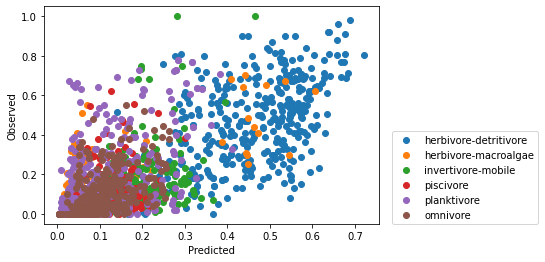

In [28]:
# Grab expected alphas
alpha = trace_dm['alpha'].T
alpha_0 = alpha.sum(0).mean(1)
Ex_alphas = alpha.mean(2)
Ex = Ex_alphas/alpha_0

## Predicted vs. observed
[plt.scatter(ei,yi,label=l) for yi,l,ei in zip(y.T,hnames,Ex)]
plt.ylabel('Observed'),plt.xlabel('Predicted')
plt.legend(loc=(1.04,0));

In [29]:
# extract posterior dists for covariates
# out = pm.trace_to_dataframe(trace_dm)
# varnames = np.array(list(out), dtype=object)
# varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(np.repeat(country, nfg))*2)
# varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = np.repeat(reef_type, nfg)
# varnames[match(grep('reefzone_x',list(varnames)),list(varnames))] = np.repeat(reef_zone, nfg)
# # varnames[match(grep('manage_x',list(varnames)),list(varnames))] = np.repeat(manage, nfg)
# varnames[match(grep('β0_manage',list(varnames)),list(varnames))] = np.array(list(np.repeat(manage, nfg))*2)

# out.columns=varnames
# out.to_csv('zinc_posterior_trace.csv', index=False)

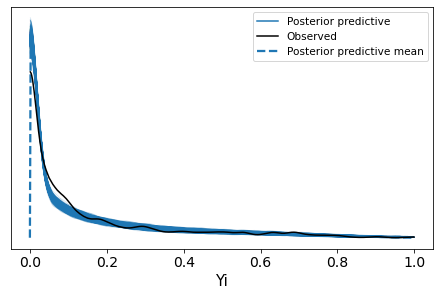

In [30]:
## posterior predictive distribution
with BDM:
    ppc = pm.sample_posterior_predictive(
        trace_dm, random_seed=43
    )

with BDM:
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc))

In [31]:
## extract posterior predicted 
extract_con(alpha='alpha2', varname = 'gravity')
extract_con(alpha='alpha3', varname = 'hard_coral')
extract_con(alpha='alpha4', varname = 'macroalgae')
extract_con(alpha='alpha5', varname = 'bare_substrate')
extract_con(alpha='alpha6', varname = 'turf')
extract_con(alpha='alpha7', varname = 'manage')
extract_con(alpha='alpha8', varname = 'pop')
extract_con(alpha='alpha9', varname = 'sediment')
extract_con(alpha='alpha10', varname = 'nut_load')
extract_con(alpha='alpha11', varname = 'rubble')
extract_con(alpha='alpha12', varname = 'future_hc')
extract_con(alpha='alpha13', varname = 'manage_nc')
extract_con(alpha='alpha14', varname = 'country')

/opt/miniconda3/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
